# CAO points analysis in 2019 - 2021  


The Central Applications Office processes applications for undergraduate courses in Irish Higher Education Institutions (HEIs).

In [1]:
# Convenient HTTP requests.
import requests as rq

# Regular expressions.
import re

# Dates and times.
import datetime as dt

# For numerical arrays.
import numpy as np

# Data frames.
import pandas as pd

# For plotting.
import matplotlib.pyplot as plt
import seaborn as sns

# For downloading.
import urllib.request as urlrq

# For loading PDFs into pandas
import camelot

In [2]:
# Get the current date and time.
now = dt.datetime.now()

# Format as a string.
nowstr = now.strftime('%Y%m%d_%H%M%S')

<br>

## 2021 Points Level 8

Taken from [cao.ie](http://www2.cao.ie/points/l8.php)
***

In [3]:
# Fetch the CAO points URL.
resp = rq.get('http://www2.cao.ie/points/l8.php')

# Testing of we getting expected response (200 means OK).
resp

<Response [200]>

<br>

## Save original data set
***

In [4]:
# Create a file path for the original data.
pathhtml = 'data/cao2021_' + nowstr + '.html'

<br>

**Fixing encoding error**

If we inspect the page in hte browser, server says we should decode as per:  

```
Content-Type: text/html; charset=iso-8859-1
```
     
However, one line uses #x96 character which isn't defined in iso-8859-1.
Therefore to fix this issue we going to use very similar standart cp1252,
which includes #x96 character

In [5]:
# The server uses the wrong encoding, fix it.
original_encoding = resp.encoding

# Change to cp1252.
resp.encoding = 'cp1252'

In [6]:
# Save the original html file.
with open(pathhtml, 'w') as f:
    f.write(resp.text)

<br>

## Use regular expressions to select lines we want
***

In [7]:
# Compile the regular expression for matching lines.
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')

<br>

### Loop through the lines of the response
***

In [8]:
# The file path for the csv file.
path2021 = 'data/cao2021_csv_' + nowstr + '.csv'

In [9]:
# Keep track of how many courses we process.
no_lines = 0

# Open the csv file for writing.
with open(path2021, 'w') as f:
    # Write a header row.
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')
    # Loop through lines of the response.
    for line in resp.iter_lines():
        # Decode the line, using the wrong encoding!
        dline = line.decode('cp1252')
        # Match only the lines representing courses.
        if re_course.fullmatch(dline):
            # Add one to the lines counter.
            no_lines = no_lines + 1
            # The course code.
            course_code = dline[:5]
            # The course title.
            course_title = dline[7:57].strip()
            # Round one points.
            course_points = re.split(' +', dline[60:])
            if len(course_points) != 2:
                course_points = course_points[:2]
            
            # Join the fields using a comma.
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between.
            f.write(','.join(linesplit) + '\n')

# Print the total number of processed lines.
print (f'Total number of lines is {no_lines}.')

Total number of lines is 949.


<br>

**NB:** it was verified as of 03/11/2021 that there were 949 courses exactly in the CAO 2021 points list.
***

In [10]:
# Reading csv file that we have saved using pandas df
df2021 = pd.read_csv(path2021, encoding='cp1252')

In [11]:
#Checking one of the data points which has special characters infront and after number of points
df2021.iloc[162]

code                                                 CK701
title       Medicine (Undergraduate Entry - HPAT required)
pointsR1                                              #738
pointsR2                                             #737*
Name: 162, dtype: object

In [12]:
# Removing # and * from pointsR1 and pointsR2 fileds 
cols = ['pointsR1', 'pointsR2']
for col in cols:
    df2021[col] = df2021[col].map(lambda x: str(x).lstrip('#').rstrip('*'))
df2021.iloc[162]

code                                                 CK701
title       Medicine (Undergraduate Entry - HPAT required)
pointsR1                                               738
pointsR2                                               737
Name: 162, dtype: object

<br>

## 2020 Points all levels

https://www.cao.ie/index.php?page=points&p=2020
***

In [13]:
# URL to CAO points for 2020
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

<br>

### Save Original File
***

In [14]:
# Create a file path for the original data.
pathxlsx = 'data/cao2020_' + nowstr + '.xlsx'

# Save retrieved URL to the file
urlrq.urlretrieve(url2020, pathxlsx)

('data/cao2020_20220102_124725.xlsx',
 <http.client.HTTPMessage at 0x7ff9f4f49310>)

<br>

### Load Spreadsheet using pandas
***

In [15]:
# Download and parse the excel spreadsheet. After checking source data in excel, only selecting columns we might need.
df2020 = pd.read_excel(url2020, skiprows=10, usecols=[1,2,3,5,10,11])

In [16]:
df2020

,COURSE TITLE,COURSE CODE2,R1 POINTS,R2 POINTS,LEVEL,HEI
0,International Business,AC120,209,NaN,8,American College
1,Liberal Arts,AC137,252,NaN,8,American College
2,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,8,National College of Art and Design
3,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,8,National College of Art and Design
4,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,8,National College of Art and Design
...,...,...,...,...,...,...
1459,Manufacturing Engineering,WD208,188,NaN,7,Waterford Institute of Technology
1460,Software Systems Development,WD210,279,NaN,8,Waterford Institute of Technology
1461,Creative Computing,WD211,271,NaN,8,Waterford Institute of Technology
1462,Recreation and Sport Management,WD212,270,NaN,8,Waterford Institute of Technology


In [17]:
# Spot check a random row.
df2020.iloc[753]

COURSE TITLE    Road Transport Technology and Management
COURSE CODE2                                       LC286
R1 POINTS                                            264
R2 POINTS                                            NaN
LEVEL                                                  7
HEI                     Limerick Institute of Technology
Name: 753, dtype: object

In [18]:
# Spot check the last row.
df2020.iloc[-1]

COURSE TITLE    Mechanical and Manufacturing Engineering
COURSE CODE2                                       WD230
R1 POINTS                                            253
R2 POINTS                                            NaN
LEVEL                                                  8
HEI                    Waterford Institute of Technology
Name: 1463, dtype: object

In [19]:
# Select only level 8 courses
df2020_l8 = df2020.loc[df2020['LEVEL'] == 8]

In [20]:
# Dropping last two columns as we don't need them after we have already selected only level 8 courses
df2020_l8 = df2020_l8.drop(columns=['LEVEL'])
# Resetting indexes of the rows so they are unique and ordered 
df2020_l8 = df2020_l8.reset_index(drop=True)

In [21]:
df2020_l8 = df2020_l8.rename(columns={"COURSE TITLE": "title", "COURSE CODE2": "code", "R1 POINTS": "pointsR1", "R2 POINTS": "pointsR2"})
df2020_l8

,title,code,pointsR1,pointsR2,HEI
0,International Business,AC120,209,NaN,American College
1,Liberal Arts,AC137,252,NaN,American College
2,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,National College of Art and Design
3,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,National College of Art and Design
4,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,National College of Art and Design
...,...,...,...,...,...
1022,Arts (options),WD200,AQA,AQA,Waterford Institute of Technology
1023,Software Systems Development,WD210,279,NaN,Waterford Institute of Technology
1024,Creative Computing,WD211,271,NaN,Waterford Institute of Technology
1025,Recreation and Sport Management,WD212,270,NaN,Waterford Institute of Technology


In [22]:
# Removing #+matric and * from pointsR1 and pointsR2 fileds 
cols = ['pointsR1', 'pointsR2']
for col in cols:
    df2020_l8[col] = df2020_l8[col].map(lambda x: str(x).lstrip('#+matric ').rstrip('*'))

In [23]:
# Create a file path for the pandas data.
path2020 = 'data/cao2020_' + nowstr + '.csv'
path2020_l8 = 'data/cao2020_l8_' + nowstr + '.csv'

# Save pandas data frame to disk.
df2020.to_csv(path2020)
df2020_l8.to_csv(path2020_l8)

<br>

## 2019 Points

https://www.cao.ie/index.php?page=points&p=2019
***

In [24]:
# Reading PDF that was dowloaded from CAO with camelot, as by default camelot only looks at the first page of the file
# here we specify that we want all pages
cao_tables = camelot.read_pdf('data/cao2019.pdf', pages='1-end')

In [25]:
# Testing that data is now loaded ( we can see there are 18 tables/pages)
cao_tables

<TableList n=18>

In [26]:
# Checking the accuracy on the parsing (this can be checked for each page) 
cao_tables[2].parsing_report

{'accuracy': 100.0, 'whitespace': 2.27, 'order': 1, 'page': 3}

<br>

We can export out tables to csv file now, but camelot will put each table in a diffeent file whish isn't convinient for us, so we need to have a walkaround to combine everything into one file
 ```
cao_tables.export('data/cao2019_' + nowstr + '.csv', f='csv')
```

In [27]:
# Here we using for loop to go through tables, convert them to dataframes and append everything 
# Idea for using appending method was taken from [1]
df2019 = pd.DataFrame()
i=0
for table in cao_tables:
    df = cao_tables[i].df
    i=i + 1
    df2019 = df2019.append(df)
df2019

,0,1,2,3
0,Course Code INSTITUTION and COURSE,,EOS,Mid
1,,Athlone Institute of Technology,,
2,AL801,Software Design with Virtual Reality and Gaming,304,328
3,AL802,Software Design with Cloud Computing,301,306
4,AL803,Software Design with Mobile Apps and Connected...,309,337
...,...,...,...,...
37,WD200,Arts (options),221,296
38,WD210,Software Systems Development,271,329
39,WD211,Creative Computing,275,322
40,WD212,Recreation and Sport Management,274,311


In [28]:
# Renaming columns
df2019 = df2019.rename(columns={0: "code", 1: "title", 2: "pointsR1", 3: "pointsR2"})

In [29]:
# Deleting first two rows
df2019 = df2019.drop([0,1])

In [30]:
df2019

,code,title,pointsR1,pointsR2
2,AL801,Software Design with Virtual Reality and Gaming,304,328
3,AL802,Software Design with Cloud Computing,301,306
4,AL803,Software Design with Mobile Apps and Connected...,309,337
5,AL805,Network Management and Cloud Infrastructure,329,442
6,AL810,Quantity Surveying,307,349
...,...,...,...,...
37,WD200,Arts (options),221,296
38,WD210,Software Systems Development,271,329
39,WD211,Creative Computing,275,322
40,WD212,Recreation and Sport Management,274,311


In [31]:
# Resetting indexes of the rows so they are unique and ordered 
df2019 = df2019.reset_index(drop=True)

We can find rows where column code is an empty string, those rows are the names of the college which we do not need, so we going to drop those rows.

In [32]:
df2019 = df2019.drop(df2019[df2019['code'] == ''].index)

In [33]:
df2019

,code,title,pointsR1,pointsR2
0,AL801,Software Design with Virtual Reality and Gaming,304,328
1,AL802,Software Design with Cloud Computing,301,306
2,AL803,Software Design with Mobile Apps and Connected...,309,337
3,AL805,Network Management and Cloud Infrastructure,329,442
4,AL810,Quantity Surveying,307,349
...,...,...,...,...
925,WD200,Arts (options),221,296
926,WD210,Software Systems Development,271,329
927,WD211,Creative Computing,275,322
928,WD212,Recreation and Sport Management,274,311


In [34]:
# Removing # and * from pointsR1 and pointsR2 fileds 
cols = ['pointsR1', 'pointsR2']
for col in cols:
    df2019[col] = df2019[col].map(lambda x: str(x).lstrip('#+matric ').rstrip('*'))

In [35]:
# Create a file path for the data.
path2019 = 'data/cao2019_' + nowstr + '.csv'

# Save pandas data frame to disk.
df2019.to_csv(path2019)

<br>

## concat and join functions
***

In [36]:
# Selecting columns code and title from data frame  for 2021 and assigning it to courses2021
courses2021 = df2021[['code', 'title']]
courses2021

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
944,WD211,Creative Computing
945,WD212,Recreation and Sport Management
946,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


In [37]:
# We can find how many courses each college had if we group by first two letters of the 'code'
match = courses2021.groupby(courses2021.code.str[:2])

<AxesSubplot:title={'center':'Number of courses in each college'}, ylabel='college codes'>

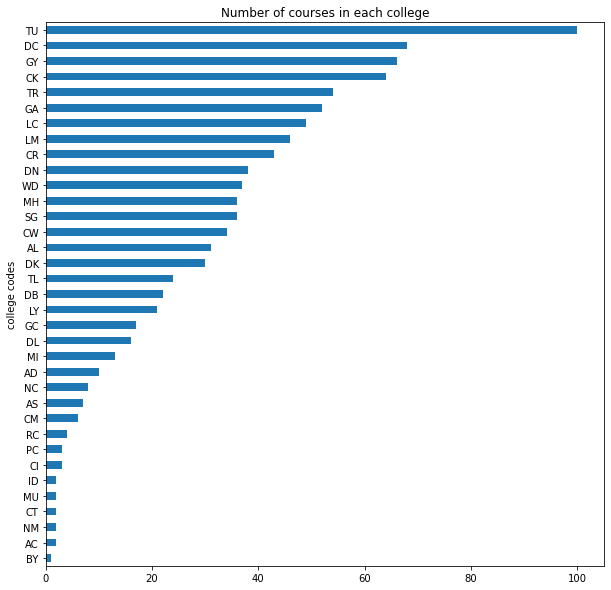

In [38]:
col = match.size()
sorted_col= col.sort_values()

sorted_col.plot(kind='barh', figsize=[10,10], xlabel='college codes', title='Number of courses in each college' )


In [39]:
# Selecting columns code and title from data frame  for 2020 and assigning it to courses2020
courses2020 = df2020_l8[['code', 'title']]
courses2020

,code,title
0,AC120,International Business
1,AC137,Liberal Arts
2,AD101,"First Year Art & Design (Common Entry,portfolio)"
3,AD102,Graphic Design and Moving Image Design (portfo...
4,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
1022,WD200,Arts (options)
1023,WD210,Software Systems Development
1024,WD211,Creative Computing
1025,WD212,Recreation and Sport Management


In [40]:
# Selecting columns code and title from data frame  for 2019 and assigning it to courses2020
courses2019 = df2019[['code', 'title']]
courses2019

,code,title
0,AL801,Software Design with Virtual Reality and Gaming
1,AL802,Software Design with Cloud Computing
2,AL803,Software Design with Mobile Apps and Connected...
3,AL805,Network Management and Cloud Infrastructure
4,AL810,Quantity Surveying
...,...,...
925,WD200,Arts (options)
926,WD210,Software Systems Development
927,WD211,Creative Computing
928,WD212,Recreation and Sport Management


In [41]:
# Combining two dataframs into one
allcourses = pd.concat([courses2021, courses2020, courses2019], ignore_index=True)
allcourses

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
2869,WD200,Arts (options)
2870,WD210,Software Systems Development
2871,WD211,Creative Computing
2872,WD212,Recreation and Sport Management


In [42]:
# Now, if we sort our data by 'code' we will see that there are a lof of duplicates, as most of the courses which run in 2019 and 2020
# were also awailable in 2021
allcourses.sort_values('code')

,code,title
175,AC120,International Business
2138,AC120,International Business
949,AC120,International Business
176,AC137,Liberal Arts
2139,AC137,Liberal Arts
...,...,...
1975,WD230,Mechanical and Manufacturing Engineering
946,WD230,Mechanical and Manufacturing Engineering
2873,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


In [43]:
# To confirm the titles of the courses were the same, which means those entries are duplicates
allcourses.loc[175]['title']

'International Business'

In [44]:
allcourses.loc[2138]['title']

'International Business'

In [45]:
allcourses.loc[949]['title']

'International Business'

In [46]:
# Finds all extra copies of duplicated rows. There are currenntly 1393 duplicates in our df
allcourses[allcourses.duplicated()]

,code,title
949,AC120,International Business
950,AC137,Liberal Arts
952,AD102,Graphic Design and Moving Image Design (portfo...
955,AD204,Fine Art (portfolio)
956,AD211,Fashion Design (portfolio)
...,...,...
2869,WD200,Arts (options)
2870,WD210,Software Systems Development
2871,WD211,Creative Computing
2872,WD212,Recreation and Sport Management


In [47]:
# Returns a copy of the data frame with duplciates removed. There are now only 1481 rows remaining. (1393+1481 = 2874 rows 
# were in total before we removed duplicates)
allcourses.drop_duplicates()

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
2814,TL801,Animation Visual Effects and Motion Design
2815,TL802,"TV, Radio and New Media"
2816,TL803,Music Technology
2819,TL812,Computing with Digital Media


In [48]:
# Finds all extra copies of duplicated rows. Now we are looking for duplicated in column 'code'
allcourses[allcourses.duplicated(subset=['code'])]

,code,title
949,AC120,International Business
950,AC137,Liberal Arts
951,AD101,"First Year Art & Design (Common Entry,portfolio)"
952,AD102,Graphic Design and Moving Image Design (portfo...
953,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
2869,WD200,Arts (options)
2870,WD210,Software Systems Development
2871,WD211,Creative Computing
2872,WD212,Recreation and Sport Management


In [49]:
# Returns a copy of the data frame with duplciates removed - based only on code. Index will be labeled strating form 0.., n-1
allcourses.drop_duplicates(subset=['code'], inplace=True, ignore_index=True)
allcourses

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
1203,SG441,Environmental Science
1204,SG446,Applied Archaeology
1205,TL803,Music Technology
1206,TL812,Computing with Digital Media


<br>

## Join to the points
***

In [50]:
# Set the index to the code column.
df2021.set_index('code', inplace=True)
df2021.columns = ['title', 'points_r1_2021', 'points_r2_2021']
df2021

,title,points_r1_2021,points_r2_2021
code,,,
AL801,Software Design for Virtual Reality and Gaming,300,nan
AL802,Software Design in Artificial Intelligence for...,313,nan
AL803,Software Design for Mobile Apps and Connected ...,350,nan
AL805,Computer Engineering for Network Infrastructure,321,nan
AL810,Quantity Surveying,328,nan
...,...,...,...
WD211,Creative Computing,270,nan
WD212,Recreation and Sport Management,262,nan
WD230,Mechanical and Manufacturing Engineering,230,230


In [51]:
# Set the index to the code column.
allcourses.set_index('code', inplace=True)

In [52]:
allcourses = allcourses.join(df2021[['points_r1_2021']])
allcourses

,title,points_r1_2021
code,,
AL801,Software Design for Virtual Reality and Gaming,300
AL802,Software Design in Artificial Intelligence for...,313
AL803,Software Design for Mobile Apps and Connected ...,350
AL805,Computer Engineering for Network Infrastructure,321
AL810,Quantity Surveying,328
...,...,...
SG441,Environmental Science,NaN
SG446,Applied Archaeology,NaN
TL803,Music Technology,NaN


In [53]:
df2020_r1 = df2020_l8[['code', 'pointsR1', 'HEI']]
df2020_r1.columns = ['code', 'points_r1_2020', 'HEI']
df2020_r1

,code,points_r1_2020,HEI
0,AC120,209,American College
1,AC137,252,American College
2,AD101,,National College of Art and Design
3,AD102,,National College of Art and Design
4,AD103,,National College of Art and Design
...,...,...,...
1022,WD200,AQA,Waterford Institute of Technology
1023,WD210,279,Waterford Institute of Technology
1024,WD211,271,Waterford Institute of Technology
1025,WD212,270,Waterford Institute of Technology


In [54]:
# Set the index to the code column.
df2020_r1.set_index('code', inplace=True)
df2020_r1

,points_r1_2020,HEI
code,,
AC120,209,American College
AC137,252,American College
AD101,,National College of Art and Design
AD102,,National College of Art and Design
AD103,,National College of Art and Design
...,...,...
WD200,AQA,Waterford Institute of Technology
WD210,279,Waterford Institute of Technology
WD211,271,Waterford Institute of Technology


In [55]:
# Join 2020 points to allcourses.
allcourses = allcourses.join(df2020_r1)
allcourses

,title,points_r1_2021,points_r1_2020,HEI
code,,,,
AL801,Software Design for Virtual Reality and Gaming,300,303,Athlone Institute of Technology
AL802,Software Design in Artificial Intelligence for...,313,332,Athlone Institute of Technology
AL803,Software Design for Mobile Apps and Connected ...,350,337,Athlone Institute of Technology
AL805,Computer Engineering for Network Infrastructure,321,333,Athlone Institute of Technology
AL810,Quantity Surveying,328,319,Athlone Institute of Technology
...,...,...,...,...
SG441,Environmental Science,NaN,NaN,NaN
SG446,Applied Archaeology,NaN,NaN,NaN
TL803,Music Technology,NaN,NaN,NaN


In [56]:
df2019_r1 = df2019[['code', 'pointsR1']]
df2019_r1.columns = ['code', 'points_r1_2019']
df2019_r1

,code,points_r1_2019
0,AL801,304
1,AL802,301
2,AL803,309
3,AL805,329
4,AL810,307
...,...,...
925,WD200,221
926,WD210,271
927,WD211,275
928,WD212,274


In [57]:
# Set the index to the code column.
df2019_r1.set_index('code', inplace=True)
df2019_r1

,points_r1_2019
code,
AL801,304
AL802,301
AL803,309
AL805,329
AL810,307
...,...
WD200,221
WD210,271
WD211,275


In [58]:
# Join 2019 points to allcourses.
allcourses = allcourses.join(df2019_r1)
allcourses

,title,points_r1_2021,points_r1_2020,HEI,points_r1_2019
code,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,303,Athlone Institute of Technology,304
AL802,Software Design in Artificial Intelligence for...,313,332,Athlone Institute of Technology,301
AL803,Software Design for Mobile Apps and Connected ...,350,337,Athlone Institute of Technology,309
AL805,Computer Engineering for Network Infrastructure,321,333,Athlone Institute of Technology,329
AL810,Quantity Surveying,328,319,Athlone Institute of Technology,307
...,...,...,...,...,...
SG441,Environmental Science,NaN,NaN,NaN,297
SG446,Applied Archaeology,NaN,NaN,NaN,289
TL803,Music Technology,NaN,NaN,NaN,264


In [59]:
# Converting points columns to float to be able to analyse the data
cols = ['points_r1_2021', 'points_r1_2020', 'points_r1_2019']
allcourses[cols] = allcourses[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [60]:
# Having a quick look on our data
allcourses.describe()

,points_r1_2021,points_r1_2020,points_r1_2019
count,923.000000,989.000000,884.000000
mean,407.666306,394.300303,378.618778
std,128.706224,126.135161,126.082890
min,57.000000,55.000000,55.000000
25%,303.000000,301.000000,290.750000
50%,391.000000,370.000000,350.000000
75%,499.000000,476.000000,443.000000
max,1028.000000,1088.000000,979.000000


In [61]:
allcourses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1208 entries, AL801 to WD148
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1208 non-null   object 
 1   points_r1_2021  923 non-null    float64
 2   points_r1_2020  989 non-null    float64
 3   HEI             1027 non-null   object 
 4   points_r1_2019  884 non-null    float64
dtypes: float64(3), object(2)
memory usage: 88.9+ KB


In [62]:
allcourses['points_r1_2021'].max()

1028.0

Here is a quick pie chart which was created with matplotlib, showing that the average points required to enter into level 8 courses in Ireland has not changed much over last 3 years (approx 1% difference between years)

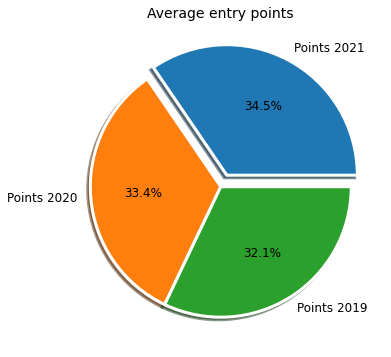

In [63]:
avg = allcourses[cols].mean()
pie, ax = plt.subplots(figsize=[10,6])
names = 'Points 2021', 'Points 2020', 'Points 2019'
labels = names
explode = (0.1, 0, 0)
plt.pie(x=avg, autopct="%.1f%%", labels=labels, textprops={'fontsize': 12}, explode=explode,shadow=True, 
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('Average entry points', fontsize=14);

Now, let's have a look at the KDE (Kernel Density Estimate) plots for different years which we can quickly create using pandas. 

<AxesSubplot:title={'center':'Entry points distribution in 2021'}, ylabel='Density'>

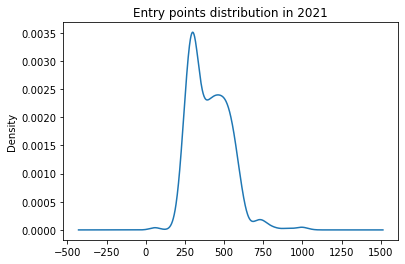

In [64]:
allcourses['points_r1_2021'].plot.kde(title='Entry points distribution in 2021')

<AxesSubplot:title={'center':'Entry points distribution in 2020'}, ylabel='Density'>

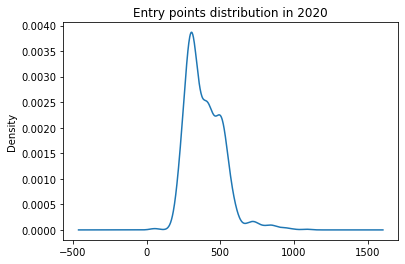

In [65]:
allcourses['points_r1_2020'].plot.kde(title='Entry points distribution in 2020')

<AxesSubplot:title={'center':'Entry points distribution in 2019'}, ylabel='Density'>

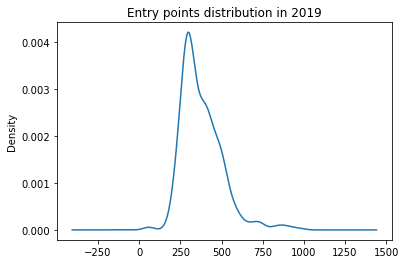

In [66]:
allcourses['points_r1_2019'].plot.kde(title='Entry points distribution in 2019')

As expected for all three years it pick around 300 points, as majority of our data confirms. In year 2021 however there is also a more pronounced secondary pick around 600 points, which doesn't exists in 2019.

We can get slightly more detailed pictures of the same using histogram plot, which this time we going to create using seaborn package. We can also add a KDE curve to it.

<AxesSubplot:xlabel='points_r1_2021', ylabel='Count'>

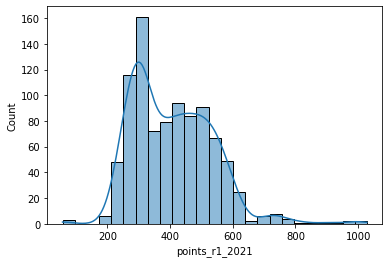

In [67]:
sns.histplot(allcourses.points_r1_2021, kde=True)

<AxesSubplot:xlabel='points_r1_2020', ylabel='Count'>

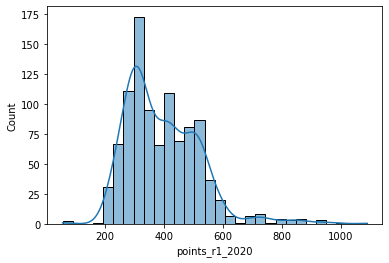

In [68]:
sns.histplot(allcourses.points_r1_2020, kde=True)

<AxesSubplot:xlabel='points_r1_2019', ylabel='Count'>

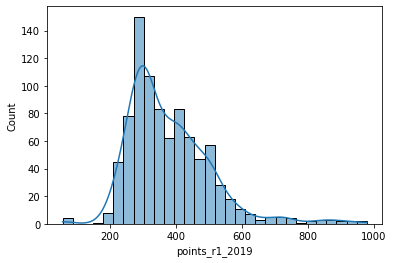

In [69]:
sns.histplot(allcourses.points_r1_2019, kde=True)

In [70]:
# Lets combine our data on code with inner join to only have the courses wich were available during all three years
temp = df2021.merge(df2020_r1, how='inner', on='code')
merged = temp.merge(df2019_r1, how='inner', on='code')

In [71]:
merged.drop(['points_r2_2021'], axis=1, inplace=True)


In [72]:
# Here we can have a look on all the colleges in our dataset
pd.unique(merged.HEI)

array(['Athlone Institute of Technology',
       'Institute of Technology, Carlow', 'Carlow College, St. Patrick`s',
       'Cork Institute of Technology', 'University College Cork (NUI)',
       'American College', 'CCT College Dublin',
       'Marino Institute of Education', 'Dublin Business School',
       'Dublin City University',
       'Dun Laoghaire Institute of Art, Design and Technology',
       'Griffith College', 'ICD Business School',
       'National College of Art and Design',
       'National College of Ireland (NCI)',
       'RCSI University of Medicine & Health Sciences',
       'Trinity College Dublin', 'University College Dublin (NUI)',
       'Dundalk Institute of Technology',
       'Galway-Mayo Institute of Technology',
       'National University of Ireland, Galway',
       'Letterkenny Institute of Technology', 'Mary Immaculate College',
       'Limerick Institute of Technology', 'University of Limerick',
       "Pontifical University, St Patrick's College",
   

In [73]:
# Converting points columns to float to be able to analyse the data
cols = ['points_r1_2021', 'points_r1_2020', 'points_r1_2019']
merged[cols] = merged[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [74]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 725 entries, AL801 to WD230
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           725 non-null    object 
 1   points_r1_2021  707 non-null    float64
 2   points_r1_2020  695 non-null    float64
 3   HEI             725 non-null    object 
 4   points_r1_2019  714 non-null    float64
dtypes: float64(3), object(2)
memory usage: 34.0+ KB


In [75]:
group_bycoll = merged.groupby(merged.HEI)

<AxesSubplot:title={'center':'Number of courses in each college'}, ylabel='colleges'>

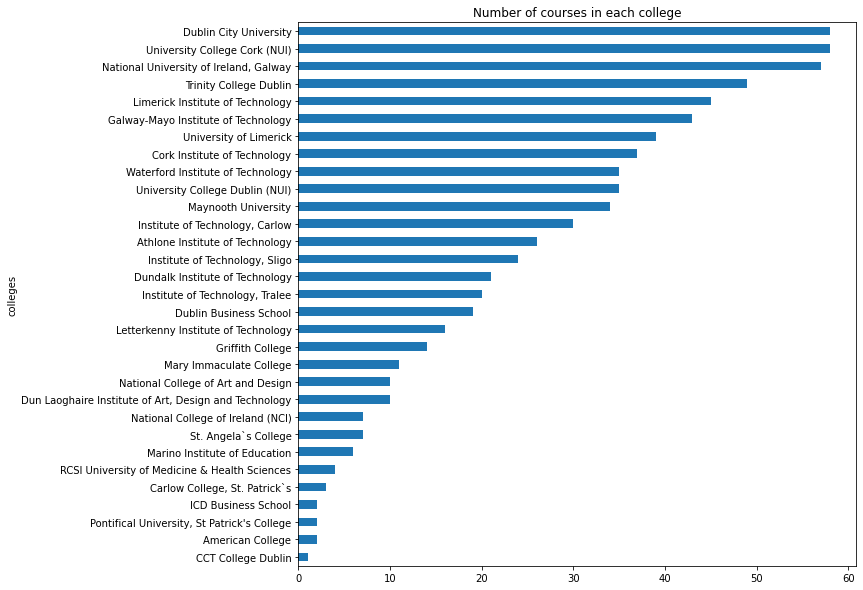

In [76]:
# Let's have a look how many different courses collegies offered
num_of_courses = group_bycoll.size().sort_values()
num_of_courses.plot(kind='barh', figsize=[10,10], xlabel='colleges', title='Number of courses in each college' )

In [87]:
# Now lets check which course required the smallest amount of points in 2021 (looking at the top 5)
small = merged.nsmallest(5,['points_r1_2021'])
small

,title,points_r1_2021,points_r1_2020,HEI,points_r1_2019
code,,,,,
LM101,Medicine - Graduate Entry (GAMSAT required),57.0,55.0,University of Limerick,55.0
CK791,Medicine - Graduate Entry (GAMSAT required),60.0,57.0,University College Cork (NUI),58.0
DN401,Medicine - Graduate Entry (GAMSAT required),61.0,NaN,University College Dublin (NUI),59.0
GA887,History and Geography,201.0,244.0,Galway-Mayo Institute of Technology,228.0
WD200,Arts (options),201.0,NaN,Waterford Institute of Technology,221.0


In [98]:
small.drop('HEI', axis=1,inplace=True)

In [131]:
df_small = small.melt( id_vars = 'title', value_vars= ['points_r1_2021', 'points_r1_2020', 'points_r1_2019'], var_name = 'year', value_name = 'poits', ignore_index=False)
#df_large.fillna(0)

df_small

,title,year,poits
code,,,
LM101,Medicine - Graduate Entry (GAMSAT required),points_r1_2021,57.0
CK791,Medicine - Graduate Entry (GAMSAT required),points_r1_2021,60.0
DN401,Medicine - Graduate Entry (GAMSAT required),points_r1_2021,61.0
GA887,History and Geography,points_r1_2021,201.0
WD200,Arts (options),points_r1_2021,201.0
LM101,Medicine - Graduate Entry (GAMSAT required),points_r1_2020,55.0
CK791,Medicine - Graduate Entry (GAMSAT required),points_r1_2020,57.0
DN401,Medicine - Graduate Entry (GAMSAT required),points_r1_2020,NaN
GA887,History and Geography,points_r1_2020,244.0


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Medicine  - Graduate Entry (GAMSAT required)'),
  Text(1, 0, 'Medicine - Graduate Entry (GAMSAT required)'),
  Text(2, 0, 'History and Geography'),
  Text(3, 0, 'Arts (options)')])

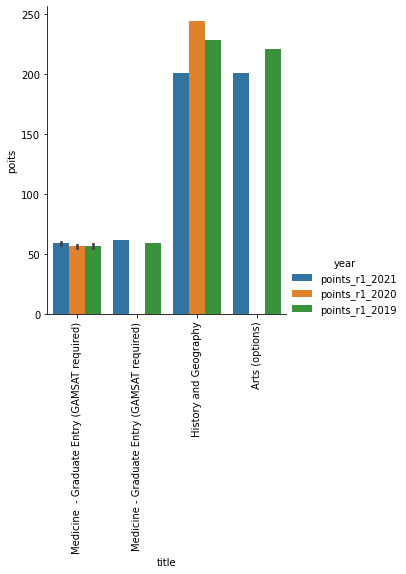

In [132]:
g = sns.catplot(x='title', y='poits', hue = 'year', data=df_small, kind='bar')
#g.legend(title='Year', labels=['2021', '2020', '2019'])
#g.show(g)
plt.xticks(rotation=90)

In [112]:
# Now lets check which course required the largest amount of points in 2021 (looking at the top 5)
large = merged.nlargest(5,['points_r1_2021'])
large.drop('HEI', axis=1,inplace=True)

In [118]:
df_large = large.melt( id_vars = 'title', value_vars= ['points_r1_2021', 'points_r1_2020', 'points_r1_2019'], var_name = 'year', value_name = 'poits', ignore_index=False)
#df_large.fillna(0)

df_large

,title,year,poits
code,,,
CR125,Popular Music at CIT Cork School of Music,points_r1_2021,1028.0
DL832,Animation,points_r1_2021,989.0
LC114,Fashion and Textiles for Product and Costume (...,points_r1_2021,914.0
CR121,Music at CIT Cork School of Music,points_r1_2021,904.0
LC502,Game Art and Design (portfolio),points_r1_2021,841.0
CR125,Popular Music at CIT Cork School of Music,points_r1_2020,1088.0
DL832,Animation,points_r1_2020,920.0
LC114,Fashion and Textiles for Product and Costume (...,points_r1_2020,880.0
CR121,Music at CIT Cork School of Music,points_r1_2020,868.0


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Popular Music at CIT Cork School of Music'),
  Text(1, 0, 'Animation'),
  Text(2, 0, 'Fashion and Textiles for Product and Costume (port'),
  Text(3, 0, 'Music at CIT Cork School of Music'),
  Text(4, 0, 'Game Art and Design (portfolio)')])

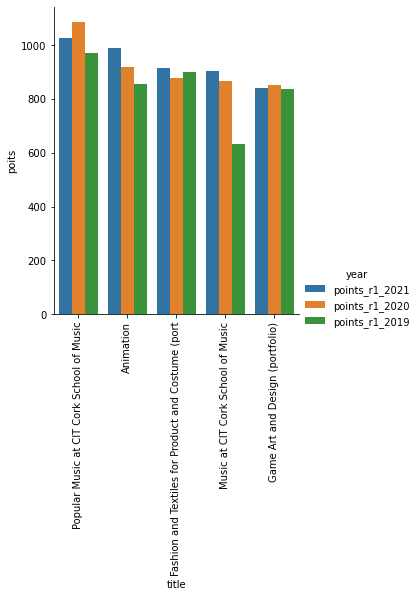

In [130]:
g = sns.catplot(x='title', y='poits', hue = 'year', data=df_large, kind='bar')
#g.legend(title='Year', labels=['2021', '2020', '2019'])
#g.show(g)
plt.xticks(rotation=90)


In [78]:
waterf= merged.where(merged['HEI']== 'Waterford Institute of Technology').dropna()

In [79]:
# Here we can see what were maximum points required in Waterford Institute in different years
# it shows that max points have increased in the last 3 years in Waterford
column = ['points_r1_2021', 'points_r1_2020', 'points_r1_2019']
max_points = waterf[column].max()

In [80]:
#We can see that both in 2021 & 2020 max points were required to enter Psychology course
waterf.loc[waterf['points_r1_2021'] == waterf['points_r1_2021'].max(), ['title']]

,title
code,
WD163,Psychology


In [81]:
waterf.loc[waterf['points_r1_2020'] == waterf['points_r1_2020'].max(), ['title']]

,title
code,
WD163,Psychology


In [82]:
# However in 2019 it was General Nursing
waterf.loc[waterf['points_r1_2019'] == waterf['points_r1_2019'].max(), ['title']]

,title
code,
WD116,General Nursing


In [83]:
waterf.describe()

,points_r1_2021,points_r1_2020,points_r1_2019
count,33.000000,33.000000,33.000000
mean,292.000000,289.121212,290.545455
std,58.688265,50.936086,42.116721
min,225.000000,216.000000,210.000000
25%,262.000000,270.000000,271.000000
50%,271.000000,272.000000,279.000000
75%,288.000000,290.000000,290.000000
max,456.000000,434.000000,413.000000


In [84]:
#The overall trend shows that the everage points slightly increase over the years
merged.describe()

,points_r1_2021,points_r1_2020,points_r1_2019
count,707.000000,695.000000,714.000000
mean,413.827440,392.676259,381.140056
std,129.842795,121.888231,120.765545
min,57.000000,55.000000,55.000000
25%,305.500000,300.500000,299.000000
50%,403.000000,375.000000,357.000000
75%,508.000000,473.500000,451.000000
max,1028.000000,1088.000000,979.000000


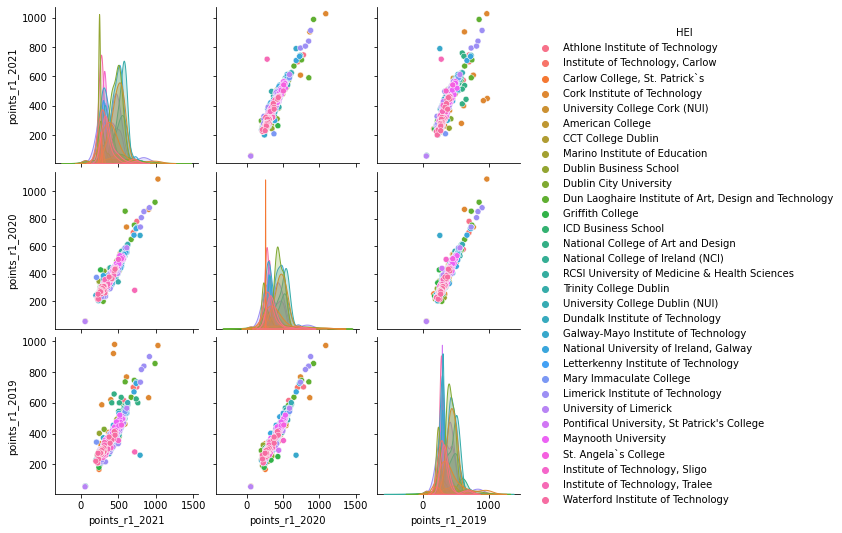

In [85]:
# We can see an overview of all the merged data using seaborn
sns.pairplot(data=merged, hue='HEI')

#### Web resources used
[1] [www.analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2020/08/how-to-extract-tabular-data-from-pdf-document-using-camelot-in-python/)  
[2] [camelot](https://camelot-py.readthedocs.io/en/master/user/install.html#install)  
[3] [pandas](https://pandas.pydata.org/docs/index.html)  
[4] [seaborn](https://seaborn.pydata.org/index.html)  

### End